In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sc
import networkx as ntx
from numpy.random import choice
import scipy.sparse.linalg as spla

In [29]:
def E0(layers):
    m1=[]
    for j in np.arange(0,8*layers,8):
        m1.append([(i+j,i+1+j) for i in range(7)])
    return np.array(m1).reshape(-1,2)
def E1(layers):
    m2=[]
    for j in np.arange(0,8*(layers-1),8):
        m2.append(np.array([((j+i,j+7+i),(j+i,j+7+2+i)) for i in np.arange(1,7,2)]))
    m2=np.array(m2).reshape(-1,2)
    return m2
def E2(layers):
    m3=[]
    m3.append([(j+7,j+14) for j in np.arange(0,8*(layers-1),8)])
    m3=np.array(m3).reshape(-1,2)
    return m3
def E3(layers):
    m4=[]
    m4.append([(8*layers+1,i) for i in np.arange(0,7,2)])
    return np.array(m4).reshape(-1,2)


def E4(layers):
    m5=[]
    m5.append([(layers*8,i) for i in np.arange((layers-1)*8+1,layers*8,2)])
    return np.array(m5).reshape(-1,2)

In [31]:
def create_graph(layers,seed):
    np.random.seed(seed)
    number_of_indices = 8*layers
    G = ntx.Graph()
    #G.add_nodes_from(range(8 * layers))
    e0 = E0(layers)
    e1 = E1(layers)
    e2 = E2(layers)
    e3 = E3(layers)
    e4 = E4(layers)
    G.add_edges_from(e0)
    G.add_edges_from(e1)
    G.add_edges_from(e2)
  #  G.add_edges_from(e3)
  #  G.add_edges_from(e4)
#    G.add_edges_from(((0,11),(6,20)))
    return G

In [49]:
def cg3d(layers, seed, depth):
    G_2d = create_graph(layers, seed)
    G_3d = ntx.Graph()

    top_node = 'top'
    bottom_node = 'bottom'
    G_3d.add_nodes_from([top_node, bottom_node])  # Add the new nodes

    for z in range(depth):
        G_3d.add_nodes_from(((node, z) for node in G_2d.nodes))
        G_3d.add_edges_from(((edge[0], z), (edge[1], z)) for edge in G_2d.edges)

        if z == 0:  # Connect top node to top layer odd nodes
            G_3d.add_edges_from((top_node, (node, z)) for node in G_2d.nodes if node % 2 == 1)
        if z == depth - 1:  # Connect bottom node to bottom layer even nodes
            G_3d.add_edges_from((bottom_node, (node, z)) for node in G_2d.nodes if node % 2 == 0)

        if z < depth - 1:  # Connect layers vertically
            G_3d.add_edges_from(((node, z), (neighbor, z + 1)) 
                                for node in G_2d.nodes if node % 2 == 1  
                                for neighbor in G_2d.neighbors(node) if neighbor % 2 == 0)
    n = G_3d.number_of_nodes()
    return G_3d,n,top_node,bottom_node


In [131]:
def create_3d_graph(layers, seed, depth):
    G_2d = create_graph(layers, seed)
    G_3d = ntx.Graph()

    max_index = max(G_2d.nodes)

    for z in range(depth):
        for node in G_2d.nodes:
            G_3d.add_node((node, z))
        for edge in G_2d.edges:
            G_3d.add_edge((edge[0], z), (edge[1], z))

        # Connect layers vertically (with no even-to-even connections)
        if z < depth - 1:
            for node in G_2d.nodes:
                if node % 2 == 1 and node < max_index:  # Only consider odd nodes
                    for neighbor in G_2d.neighbors(node):
                        if neighbor % 2 == 0:
                            G_3d.add_edge((node, z), (neighbor, z + 1))

    return G_3d

In [55]:
create_3d_graph(4, 1, 10)

In [133]:
def generate_random_values(mean, std, seed, num_edges):
    np.random.seed(seed)
    return np.abs(np.random.normal(mean, std, num_edges))

In [169]:
def matrix_interactions(seed,depth,h,std):
    grid = create_3d_graph(4,seed,depth)
    num_edges = grid.number_of_edges()
    nodes = grid.number_of_nodes()
#    print(nodes)
    cap_values = np.abs(1*generate_random_values(10, std, seed, num_edges))
    
    adjM = sc.lil_matrix((nodes, nodes))
    xxx = list(grid.edges())
    interactions = 1/cap_values
    
    for edge_idx, (i, j) in enumerate(xxx):
        interaction_value = interactions[edge_idx]
        adjM[i, j] = interaction_value
        adjM[j, i] = interaction_value
        
    adjM.setdiag(-1*adjM.sum(axis=1).A1 - 0.0001)
    
    MI = spla.inv(-1*adjM.tocsc())  # Using inv for CSC matrices
    
    return adjM,nodes

In [177]:
n,m = matrix_interactions(2,2,0,0)

In [191]:
n.toarray()[13]

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.1   , -0.4001,
        0.1   ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.1   ,
        0.    ,  0.1   ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ])

In [137]:
def R(a,b,std):
    MI,nodes = matrix_interactions(4,50,1,std)
    return MI[a, b] + MI[b, b] - MI[a,b] - MI[b, a] 

In [155]:
j1=[R(0,h,0) for h in np.arange(0,1599,1)]

In [123]:
j2=[R(0,7,h) for h in np.arange(0,5,0.1)]

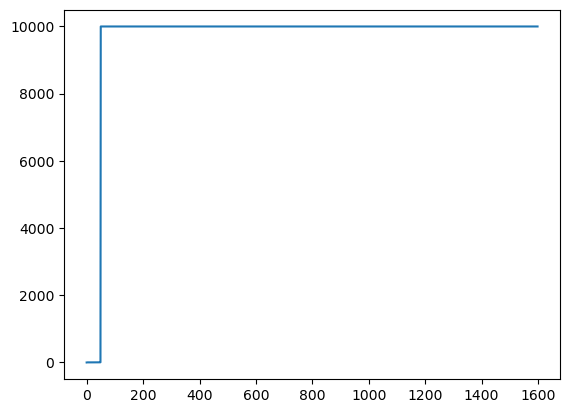

In [156]:
plt.plot(j1)

In [128]:
jin=[R(0,31,h) for h in np.arange(0.01,1,0.01)]

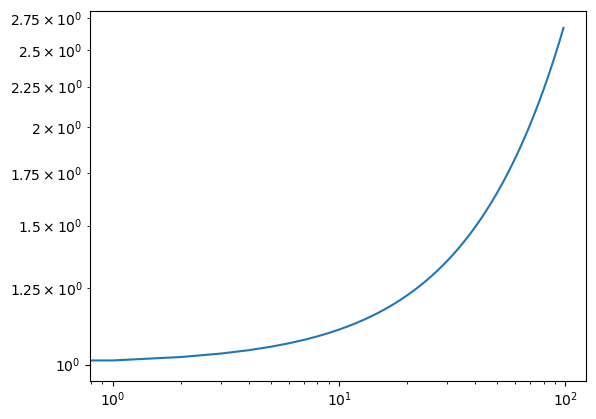

In [142]:
plt.loglog(jin)

In [105]:
def visualize_3d_graph(G):
    pos = ntx.spring_layout(G, dim=3, seed=42)  # 3D layout
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ntx.draw(G, with_labels=True, node_size=100, font_size=8)
    ax.set_axis_off()  # Optional: Remove axis lines for cleaner look
    plt.show()

In [107]:
visualize_3d_graph(create_3d_graph(2, 1,4))

TypeError: Axes3D.text() missing 1 required positional argument: 's'

Error in callback <function _draw_all_if_interactive at 0x7c05204551c0> (for post_execute):


AttributeError: 'LineCollection' object has no attribute 'do_3d_projection'

AttributeError: 'LineCollection' object has no attribute 'do_3d_projection'

<Figure size 640x480 with 1 Axes>